In [ ]:
%matplotlib inline
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to process each data file
def process_data(file_path):
    with open(file_path) as f:
        data = json.load(f)

    performance_rows = []
    memory_rows = []

    for entry in data:
        measurement = entry['measurement']
        
        if 'performance' in measurement:
            structure = measurement['performance']['structure']
            action = measurement['performance']['action']
            qty_or_after = measurement['performance'].get('qty', measurement['performance'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['performance'] else 'after'
            time = measurement['performance']['time']
            performance_rows.append([structure, action, metric_type, qty_or_after, time])
        
        if 'memory' in measurement:
            structure = measurement['memory']['structure']
            action = measurement['memory']['action']
            qty_or_after = measurement['memory'].get('qty', measurement['memory'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['memory'] else 'after'
            size = measurement['memory']['size']
            memory_rows.append([structure, action, metric_type, qty_or_after, size])

    performance_df = pd.DataFrame(performance_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'time'])
    memory_df = pd.DataFrame(memory_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'size'])
    
    return performance_df, memory_df

# Process all three files
performance_dfs = []
memory_dfs = []

for i in range(1, 4):
    perf_df, mem_df = process_data(f"../output/specReports/benchmark.report.{i}.json")  # Change the path as per your file locations
    performance_dfs.append(perf_df)
    memory_dfs.append(mem_df)

# Concatenate dataframes
all_performance_df = pd.concat(performance_dfs)
all_memory_df = pd.concat(memory_dfs)

# Group by necessary columns and calculate the mean
performance_df = all_performance_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()
memory_df = all_memory_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()

# Log1p Transformation with handling zero/negative values


# Log1p Transformation with handling zero/negative values
def log1p_transform(df, value_column, exclude_actions):
    epsilon = 1e-10  # Small constant to avoid log(0)
    df[value_column] = df.apply(lambda row: np.log1p(row[value_column] + epsilon) if row['action'] not in exclude_actions and row[value_column] > 0 else row[value_column], axis=1)
    return df

# Actions to be excluded from log1p transformation
exclude_actions = [
    'addNodeMetadata', 
    'findNodeById', 
    'findConnectionById',
    #'findNodesByType', 
    'removeNodeById',
    'removeConnectionById',
    'updateNodeMetadata',
]

# Apply log1p transformation to time and size columns
performance_df = log1p_transform(performance_df, 'time', exclude_actions)
memory_df = log1p_transform(memory_df, 'size', exclude_actions)

# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=['structure', 'action', 'metric_type', 'metric_value'], suffixes=('_time', '_memory'))

# Combine metric type and value for unique x-axis labels
merged_df['metric'] = merged_df['metric_type'] + ': ' + merged_df['metric_value'].astype(str)

print(merged_df.nunique())

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['structure', 'metric_type', 'metric_value'])

# Check the number of time and size values for each structure-action pair
print(merged_df.groupby(['action'])['metric'].count())

merged_df.head()

In [ ]:
# Plotting the combined graphs with log1p scale and annotations
def plot_combined_graph(df, action):
    subset = df[df['action'] == action]
    pivot_time_df = subset.pivot(index='metric', columns='structure', values='time')
    pivot_memory_df = subset.pivot(index='metric', columns='structure', values='size')
    

    fig, ax1 = plt.subplots(figsize=(16, 9))  # Increase figure size

    bar_width = 0.3  # Adjust the bar width
    rotation_angle = 0  # Adjust the rotation angle for x-tick labels

    # Plot time bars
    ax1.set_xlabel('Metric (qty/after)')
    ax1.set_ylabel('Time (log1p-transformed)', color='tab:blue')
    bars1 = pivot_time_df.plot(
        kind='bar', ax=ax1, position=1, width=bar_width, 
        color=['tab:blue', 'tab:cyan'], legend=False, edgecolor='black'
    )
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Plot memory bars
    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory (log1p-transformed)', color='tab:red')
    bars2 = pivot_memory_df.plot(
        kind='bar', ax=ax2, position=0, width=bar_width, 
        color=['tab:red', 'tab:pink'], legend=False, edgecolor='orange'
    )
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Annotate bars with their values
    def annotate_bars(ax, bars, color='black'):
        for bar in bars.patches:
            height = bar.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height), 
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", 
                            ha='center', va='bottom', color=bar.get_facecolor()
                            )

    annotate_bars(ax1, bars1)
    annotate_bars(ax2, bars2)

    fig.tight_layout(pad=3)
    fig.suptitle(f'Performance and Memory Consumption of {action} function', y=1.02)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), title='Structure - Time (ms)')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), title='Structure - Memory (bytes)')

    plt.show()

    # Save the plot as an image
    fig.savefig(f'../output/plots/{action}_combined.png', bbox_inches='tight')  # Change the path as per your file locations

keys = [
    'createNodes', 
    'addNode', 
    'addNodes', 
    'moveAllNodes', 
    'addNodeMetadata', 
    'findNodeById', 
    'findNodesByType', 
    'removeNodeById'
]

keys = [
    "addConnection",
    "addConnections",
    "addNode",
    "addNodes",
    "addNodeMetadata",
    "updateNodeMetadata"
    "findConnectionById",
    "findNodeById",
    "removeConnectionById",
    "removeNodeById",
    "translateConnection",
    "translateNode",
    "updateConnection",
    "updateNode"
]

actions = merged_df['action'].unique()

# Plot combined graphs for each action
for action in actions:#sorted(merged_df['action'].unique(), key=lambda x: keys.index(x)):
    print(f'Plotting combined graph for {action}')
    plot_combined_graph(merged_df, action)

#print(merged_df)

In [ ]:

def pp(*args):
    print("\n".join(map(str, args)))

fp = "/home/dimitriy/Effect_Healthcare/graph.structure/output/specReports/benchmark.report.1.json"

with open(fp, "r") as f:
    data = json.load(f)

specDescriptions = set()
for entry in data:
    desc = entry["spec"]
    specDescriptions.add(desc)


funcSignatures = set()
for desc in specDescriptions:
    funcCall = desc.split("graph.")[1].split(")")[0]+")"
    funcSignatures.add(funcCall)

funcNames = set()
for func in funcSignatures:
    funcName = func.split("(")[0]
    funcNames.add(funcName)

keys = [
    "addConnection",
    "addConnections",
    "addNode",
    "addNodes",
    "addNodeMetadata",
    "updateNodeMetadata"
    "findConnectionById",
    "findNodeById",
    "removeConnectionById",
    "removeNodeById",
    "translateConnection",
    "translateNode",
    "updateConnection",
    "updateNode"
]


In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to process each data file
def process_data(file_path):
    with open(file_path) as f:
        data = json.load(f)

    performance_rows = []
    memory_rows = []

    for entry in data:
        measurement = entry['measurement']
        
        if 'performance' in measurement:
            structure = measurement['performance']['structure']
            action = measurement['performance']['action']
            qty_or_after = measurement['performance'].get('qty', measurement['performance'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['performance'] else 'after'
            time = measurement['performance']['time']
            performance_rows.append([structure, action, metric_type, qty_or_after, time])
        
        if 'memory' in measurement:
            structure = measurement['memory']['structure']
            action = measurement['memory']['action']
            qty_or_after = measurement['memory'].get('qty', measurement['memory'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['memory'] else 'after'
            size = measurement['memory']['size']
            memory_rows.append([structure, action, metric_type, qty_or_after, size])

    performance_df = pd.DataFrame(performance_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'time'])
    memory_df = pd.DataFrame(memory_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'size'])
    
    return performance_df, memory_df

# Process all files
performance_dfs = []
memory_dfs = []

# Assuming there are multiple files benchmark.report.1.json, benchmark.report.2.json, benchmark.report.3.json
for i in range(1, 4):
    perf_df, mem_df = process_data(f"../output/specReports/benchmark.report.{i}.json")  # Update the path if needed
    performance_dfs.append(perf_df)
    memory_dfs.append(mem_df)

# Concatenate dataframes
all_performance_df = pd.concat(performance_dfs)
all_memory_df = pd.concat(memory_dfs)

# Group by necessary columns and calculate the mean
performance_df = all_performance_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()
memory_df = all_memory_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()

# Log1p Transformation with handling zero/negative values
excluded_actions = [
    'addNodeMetadata', 
    'findNodeById', 
    'findConnectionById',
    'removeNodeById',
    'removeConnectionById',
    'updateNodeMetadata',
]

def log1p_transform(df, value_column, excluded_actions):
    epsilon = 1e-10  # Small constant to avoid log(0)
    df[value_column] = df.apply(
        lambda row: np.log1p(row[value_column] + epsilon) if row['action'] not in excluded_actions and row[value_column] > 0 else row[value_column], 
        axis=1
    )
    return df

# Apply log1p transformation to time and size columns
#performance_df = log1p_transform(performance_df, 'time', excluded_actions)
#memory_df = log1p_transform(memory_df, 'size', excluded_actions)

print(performance_df[performance_df['action'] == 'removeNodeById'])
# Normalize data within each action
def normalize(df, value_column):
    min_value = df[value_column].min()
    max_value = df[value_column].max()

    denom = max_value - min_value
    numerator = df[value_column] - min_value
    if denom == 0:
        print(f'Cannot normalize {value_column} for {df["action"].iloc[0]}')
        denom = 1
        #return df

    if numerator.max() == 0:
        print(f'Cannot normalize {value_column} for {df["action"].iloc[0]}')
        numerator = 1


    
    df[value_column] = (df[value_column] - min_value) / denom
    return df

# Normalize time and size columns
performance_df = performance_df.groupby(['action']).apply(normalize, 'time').reset_index(drop=True)
memory_df = memory_df.groupby(['action']).apply(normalize, 'size').reset_index(drop=True)


# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=['structure', 'action', 'metric_type', 'metric_value'], suffixes=('_time', '_memory'))

# Combine metric type and value for unique x-axis labels
merged_df['metric'] = merged_df['metric_type'] + ': ' + merged_df['metric_value'].astype(str)

# Plotting the combined graphs with log1p scale and annotations
def plot_combined_graph(df, action):
    subset = df[df['action'] == action]
    pivot_time_df = subset.pivot(index='metric', columns='structure', values='time')
    pivot_memory_df = subset.pivot(index='metric', columns='structure', values='size')

    fig, ax1 = plt.subplots(figsize=(16, 9))  # Increase figure size

    bar_width = 0.3  # Adjust the bar width
    rotation_angle = 45  # Adjust the rotation angle for x-tick labels

    # Plot time bars
    ax1.set_xlabel('Metric (qty/after)')
    ax1.set_ylabel('Time (log1p-transformed)' if action not in excluded_actions else 'Time', color='tab:blue')
    bars1 = pivot_time_df.plot(
        kind='bar', ax=ax1, position=1, width=bar_width, 
        color=['tab:blue', 'tab:cyan'], legend=False, edgecolor='black'
    )
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Plot memory bars
    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory (log1p-transformed)' if action not in excluded_actions else 'Memory', color='tab:red')
    bars2 = pivot_memory_df.plot(
        kind='bar', ax=ax2, position=0, width=bar_width, 
        color=['tab:red', 'tab:pink'], legend=False, edgecolor='black'
    )
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Annotate bars with their values
    def annotate_bars(ax, bars):
        for bar in bars.patches:
            height = bar.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height), 
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", 
                            ha='center', va='bottom', color='black'
                            )

    annotate_bars(ax1, bars1)
    annotate_bars(ax2, bars2)

    fig.tight_layout(pad=3)
    fig.suptitle(f'Performance and Memory Consumption of {action} function', y=1.02)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), title='Structure - Time')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), title='Structure - Memory')

    plt.show()

    # Save the plot as an image
    plot_dir = "../output/plots"
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    fig.savefig(f'{plot_dir}/{action}_combined.png', bbox_inches='tight')  # Change the path as per your file locations

keys = [
    "addConnection",
    "addConnections",
    "addNode",
    "addNodes",
    "addNodeMetadata",
    "updateNodeMetadata",
    "findConnectionById",
    "findNodeById",
    "removeConnectionById",
    "removeNodeById",
    "translateConnection",
    "translateNode",
    "updateConnection",
    "updateNode"
]

# Plot combined graphs for each action
for action in sorted(merged_df['action'].unique(), key=lambda x: keys.index(x)):
    plot_combined_graph(merged_df, action)
    #pass


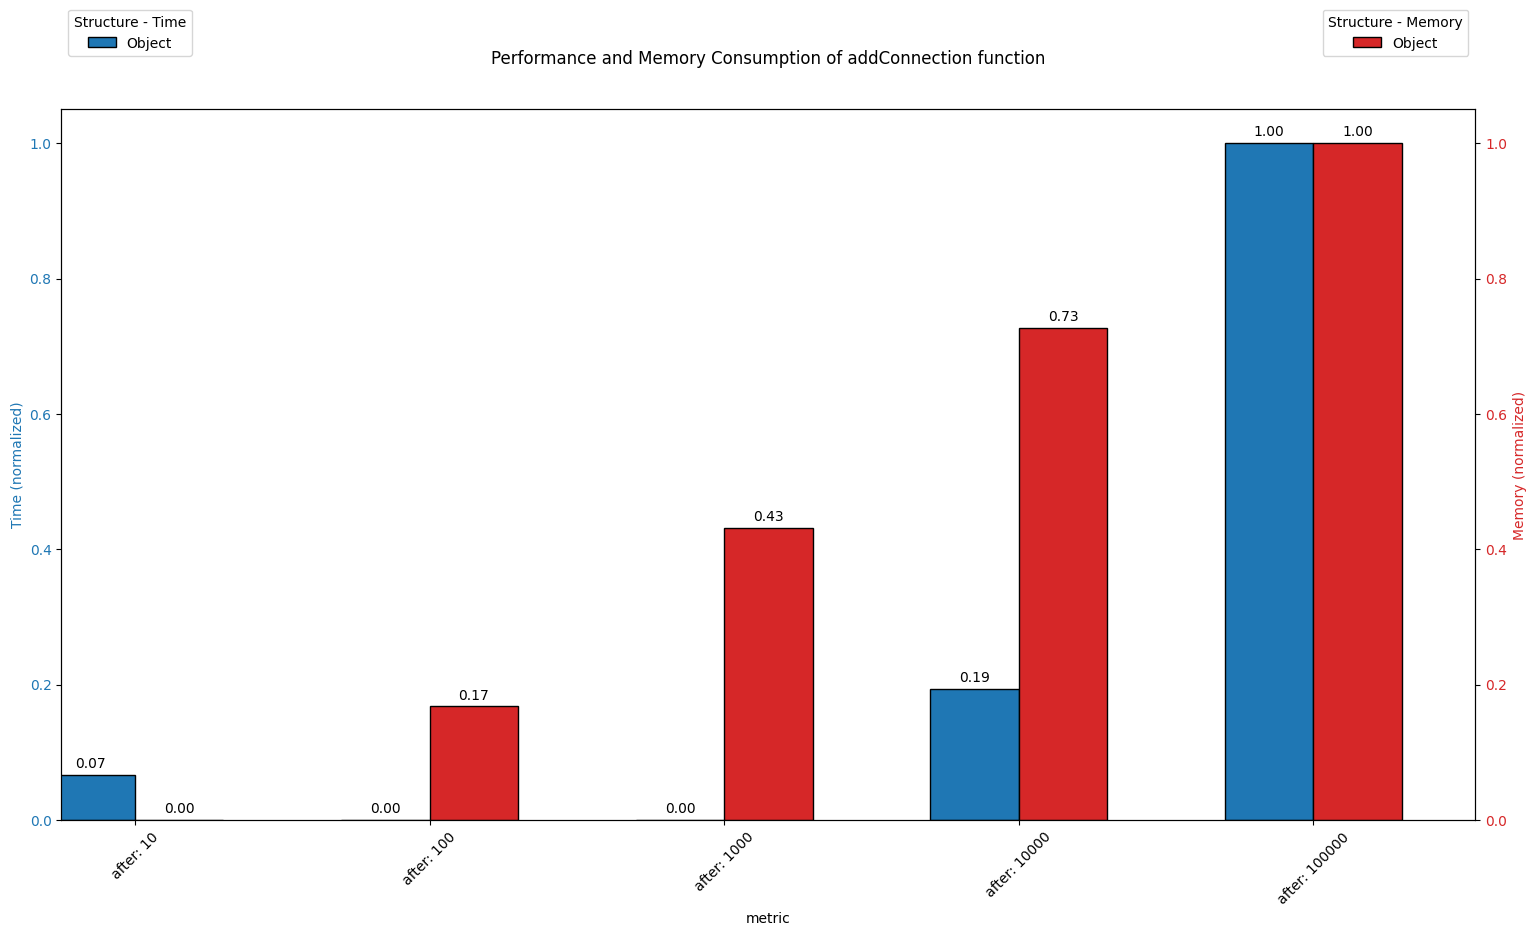

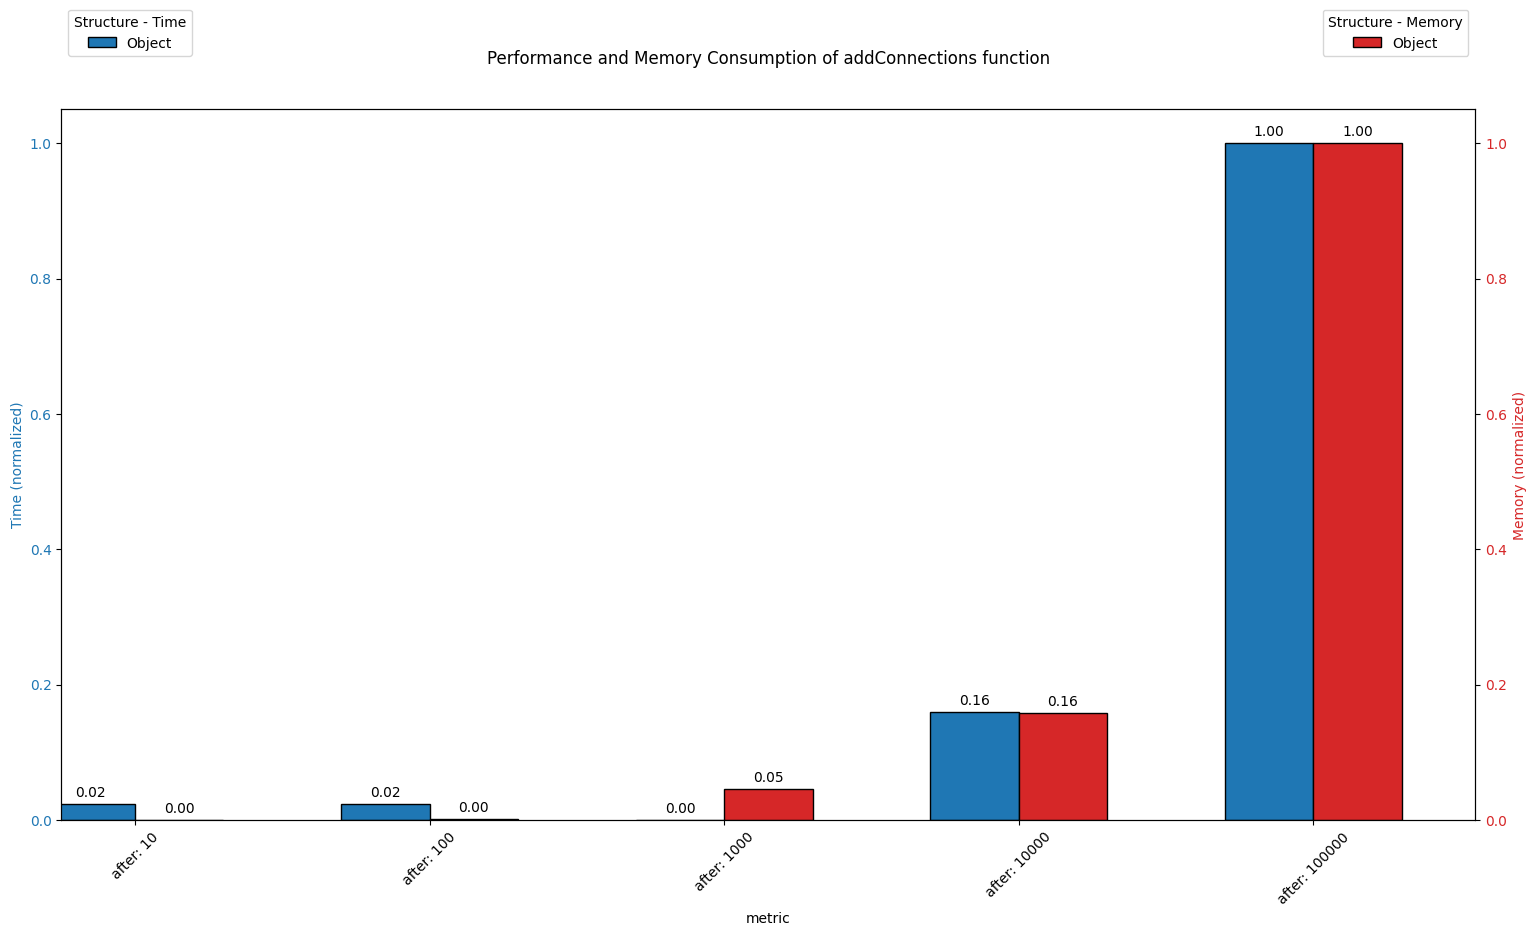

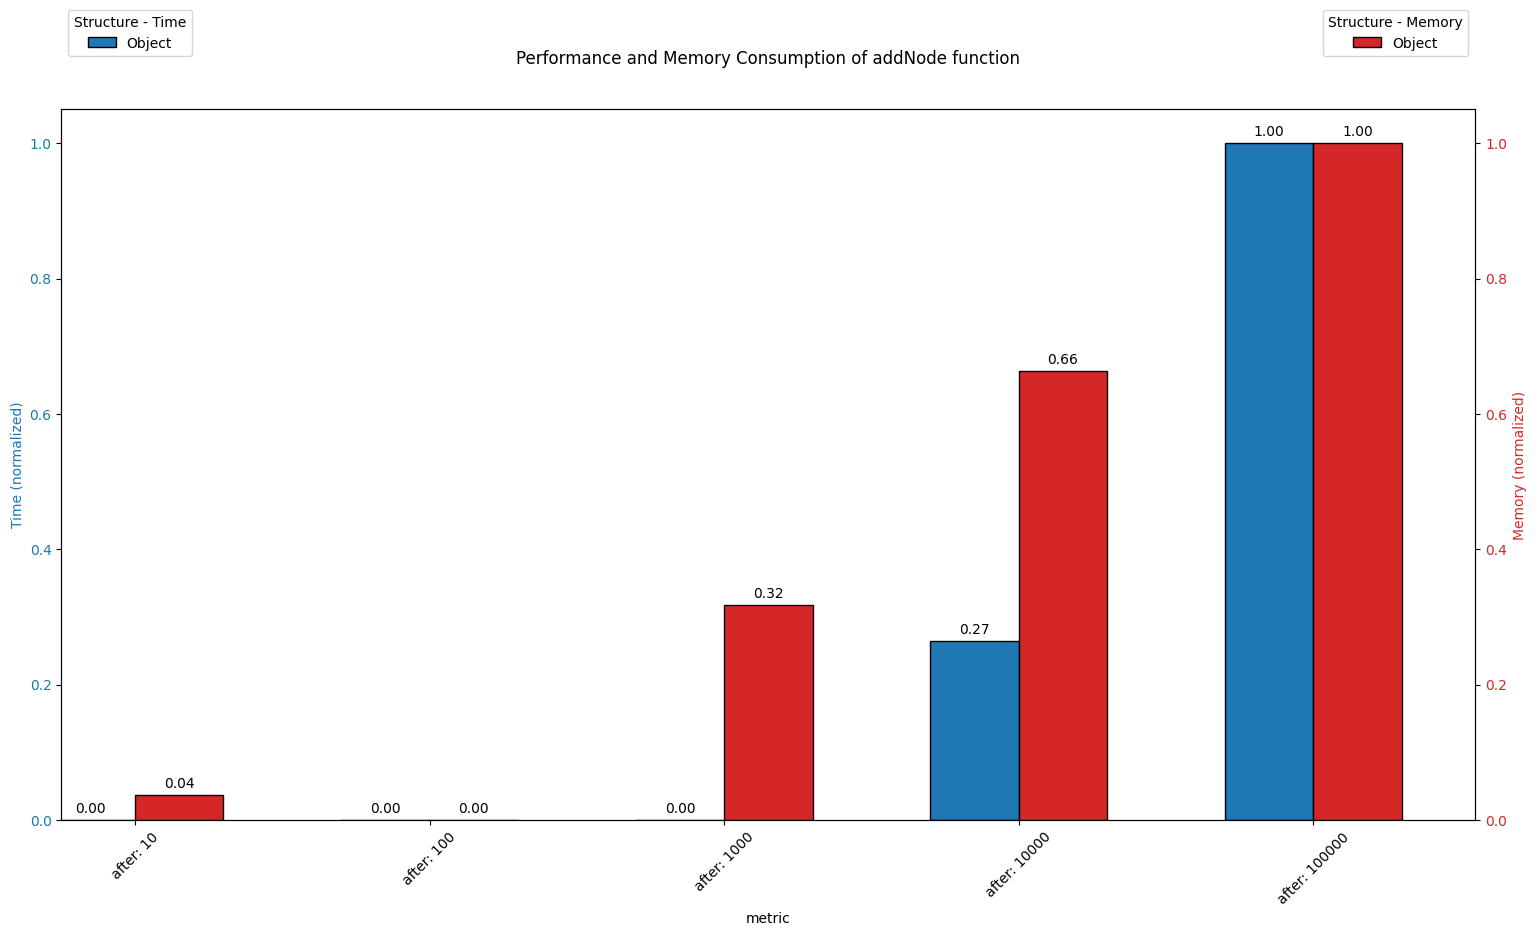

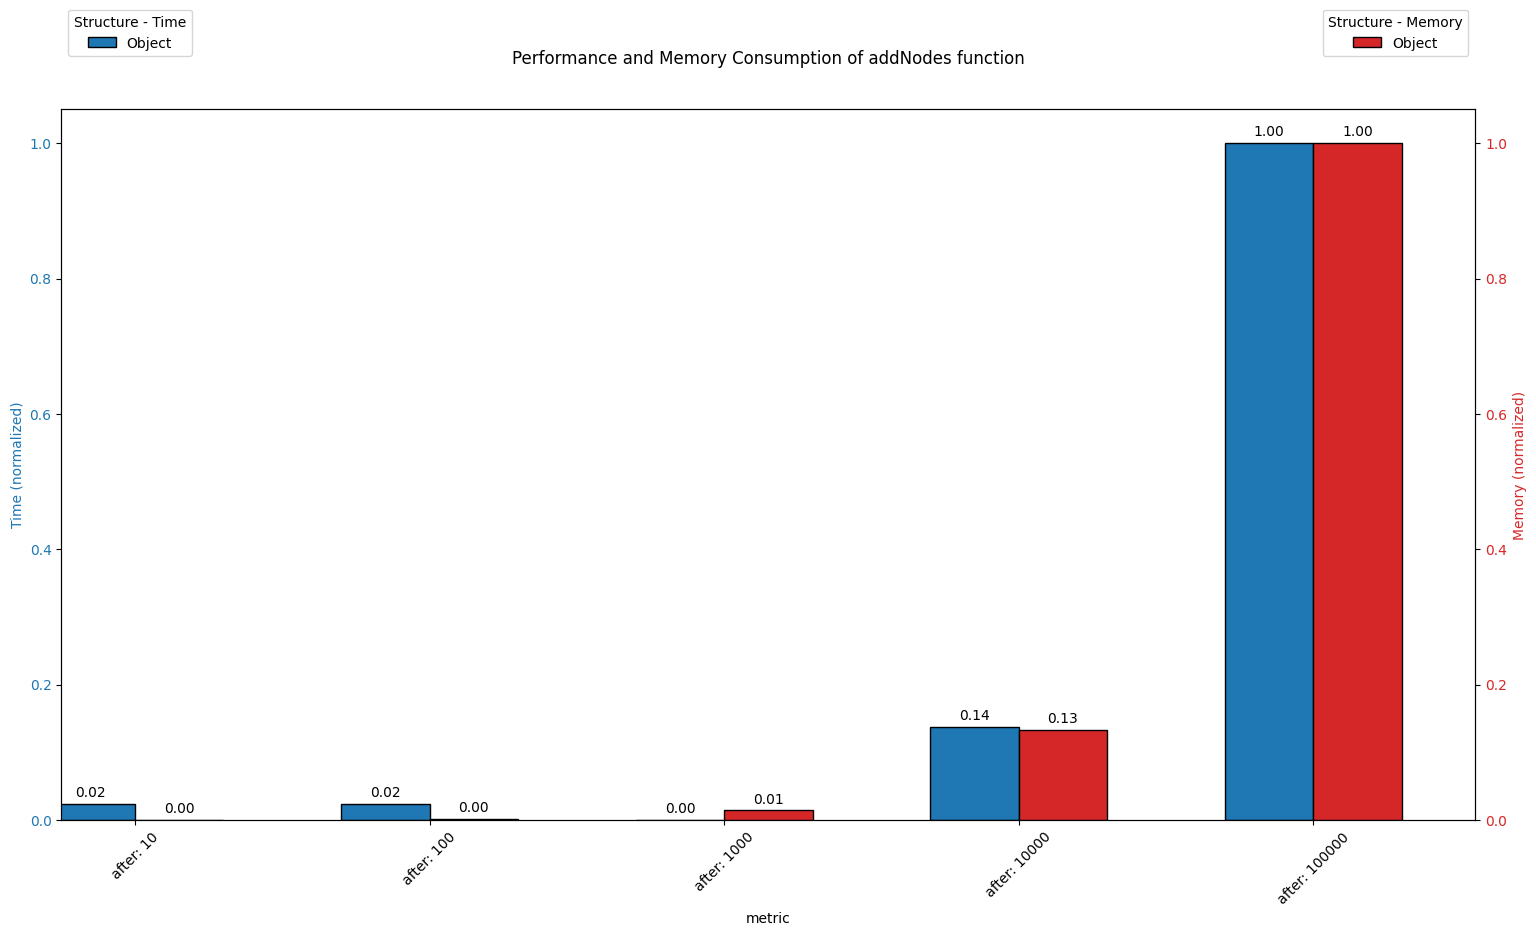

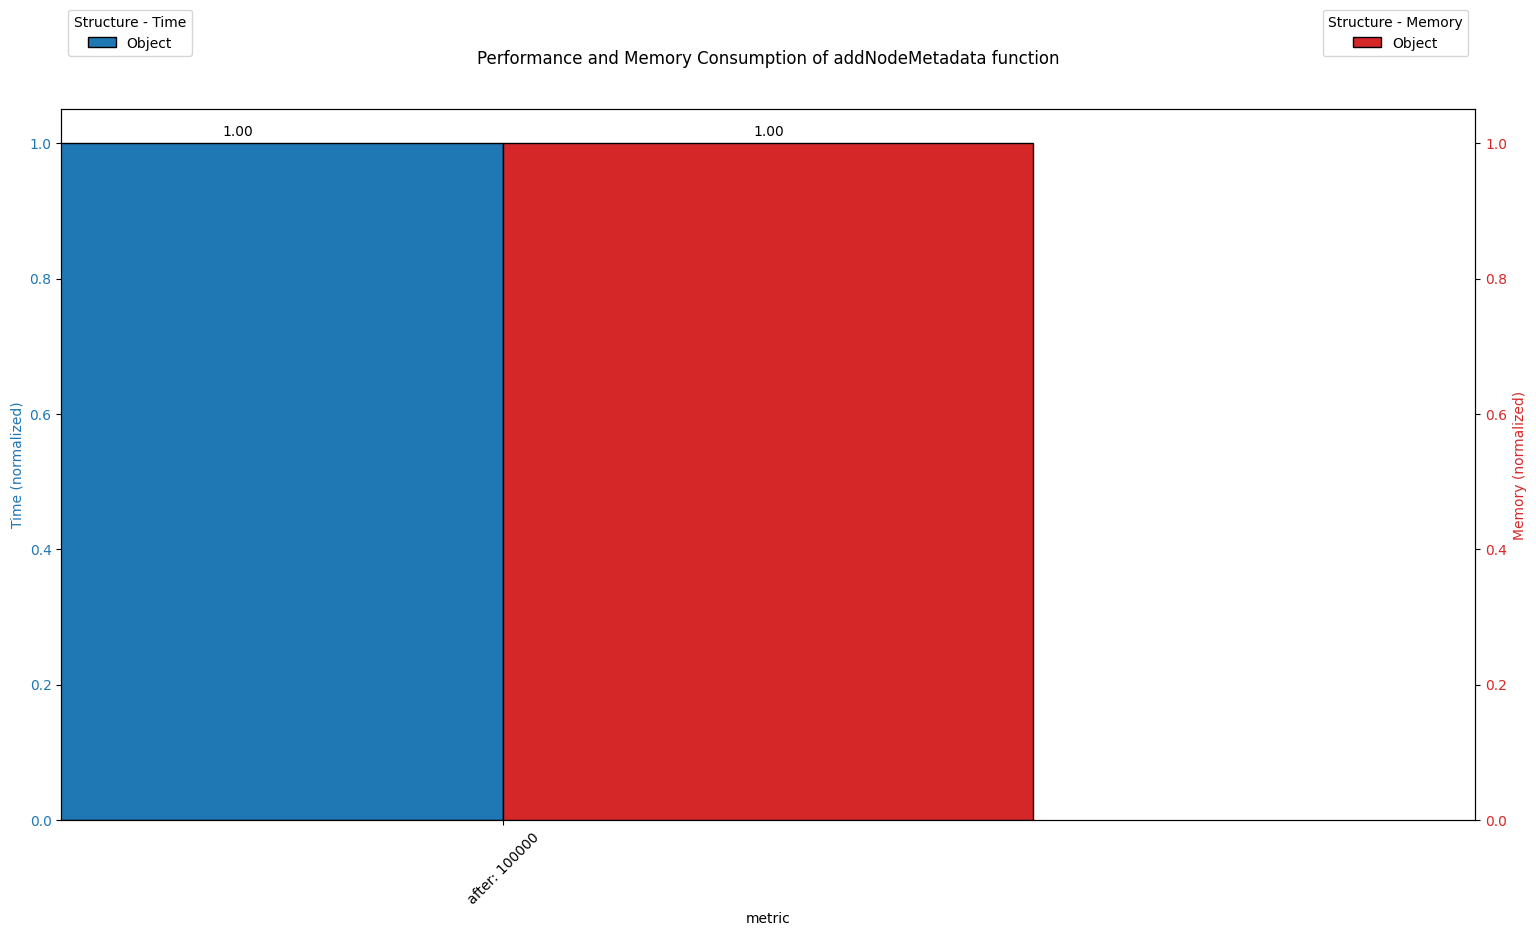

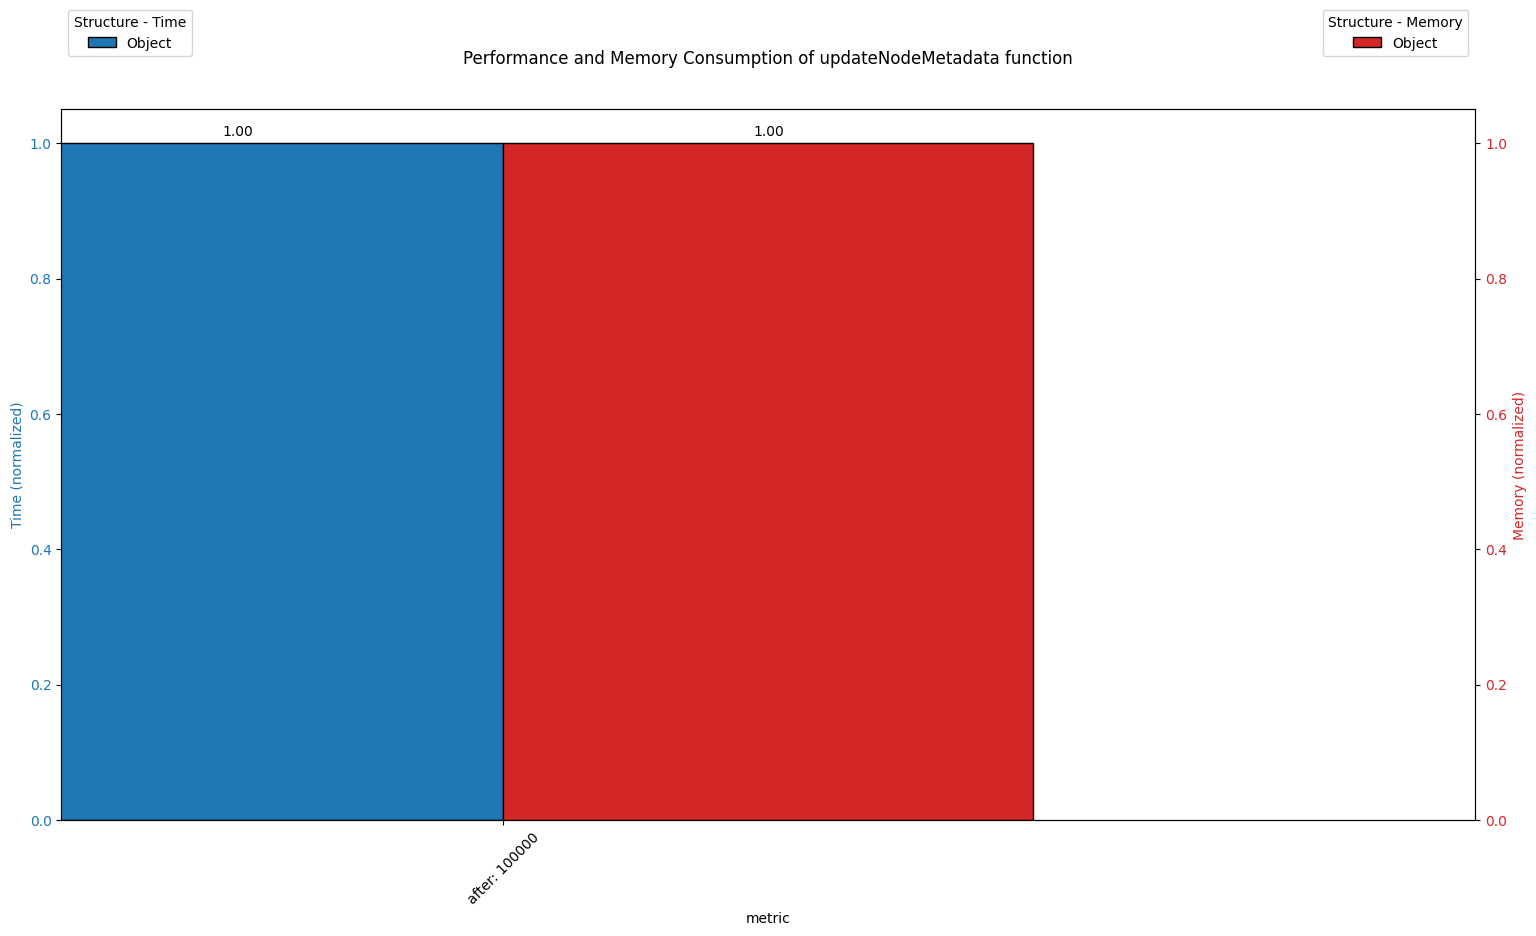

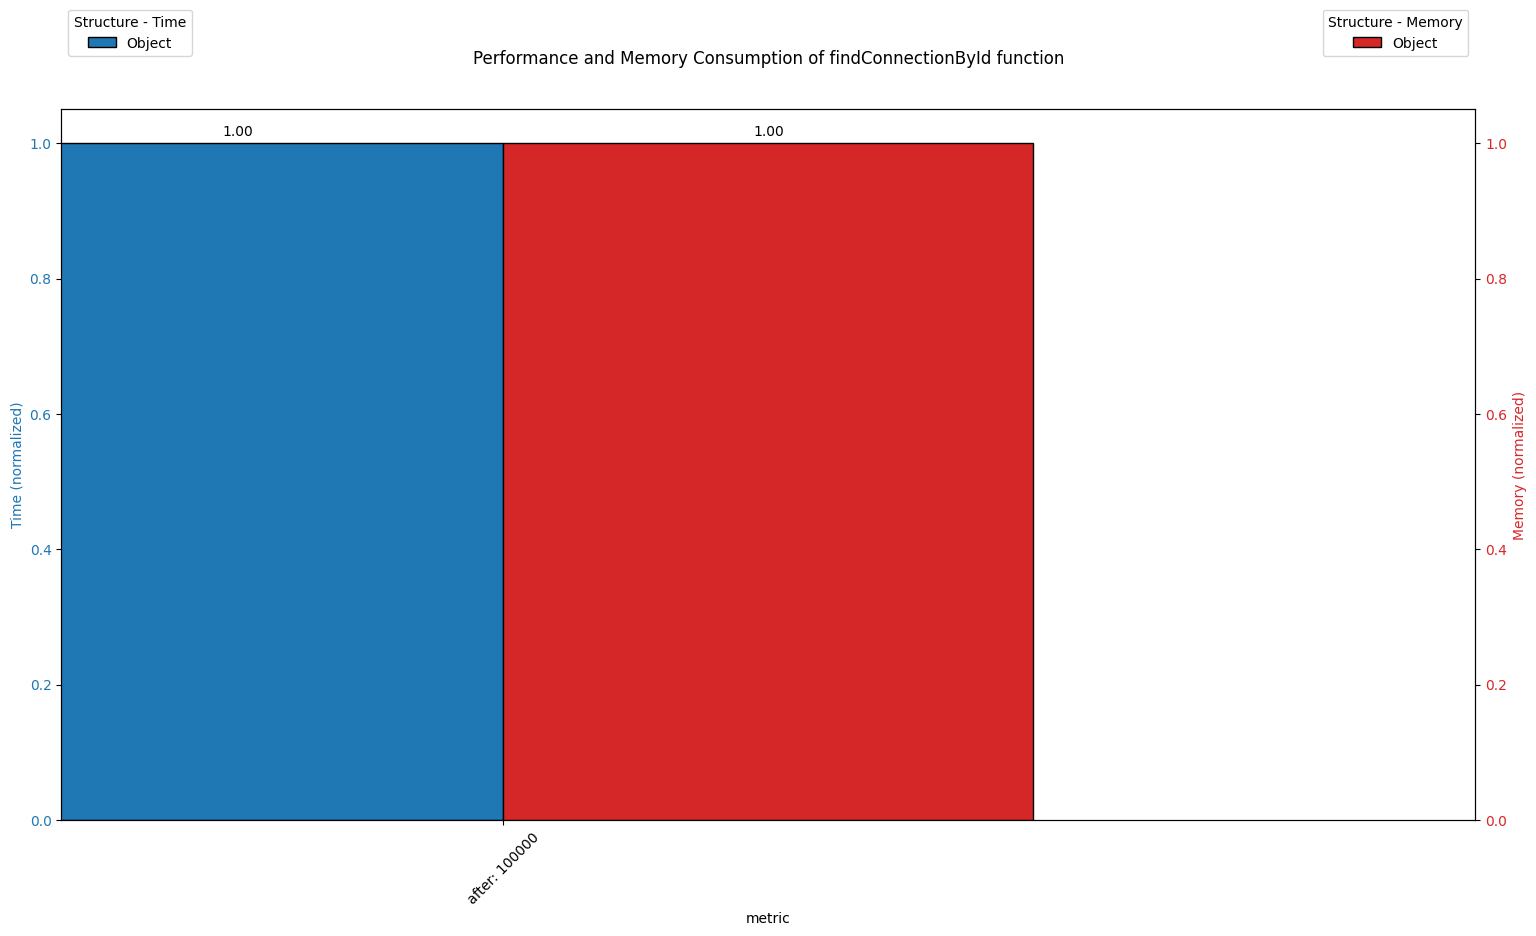

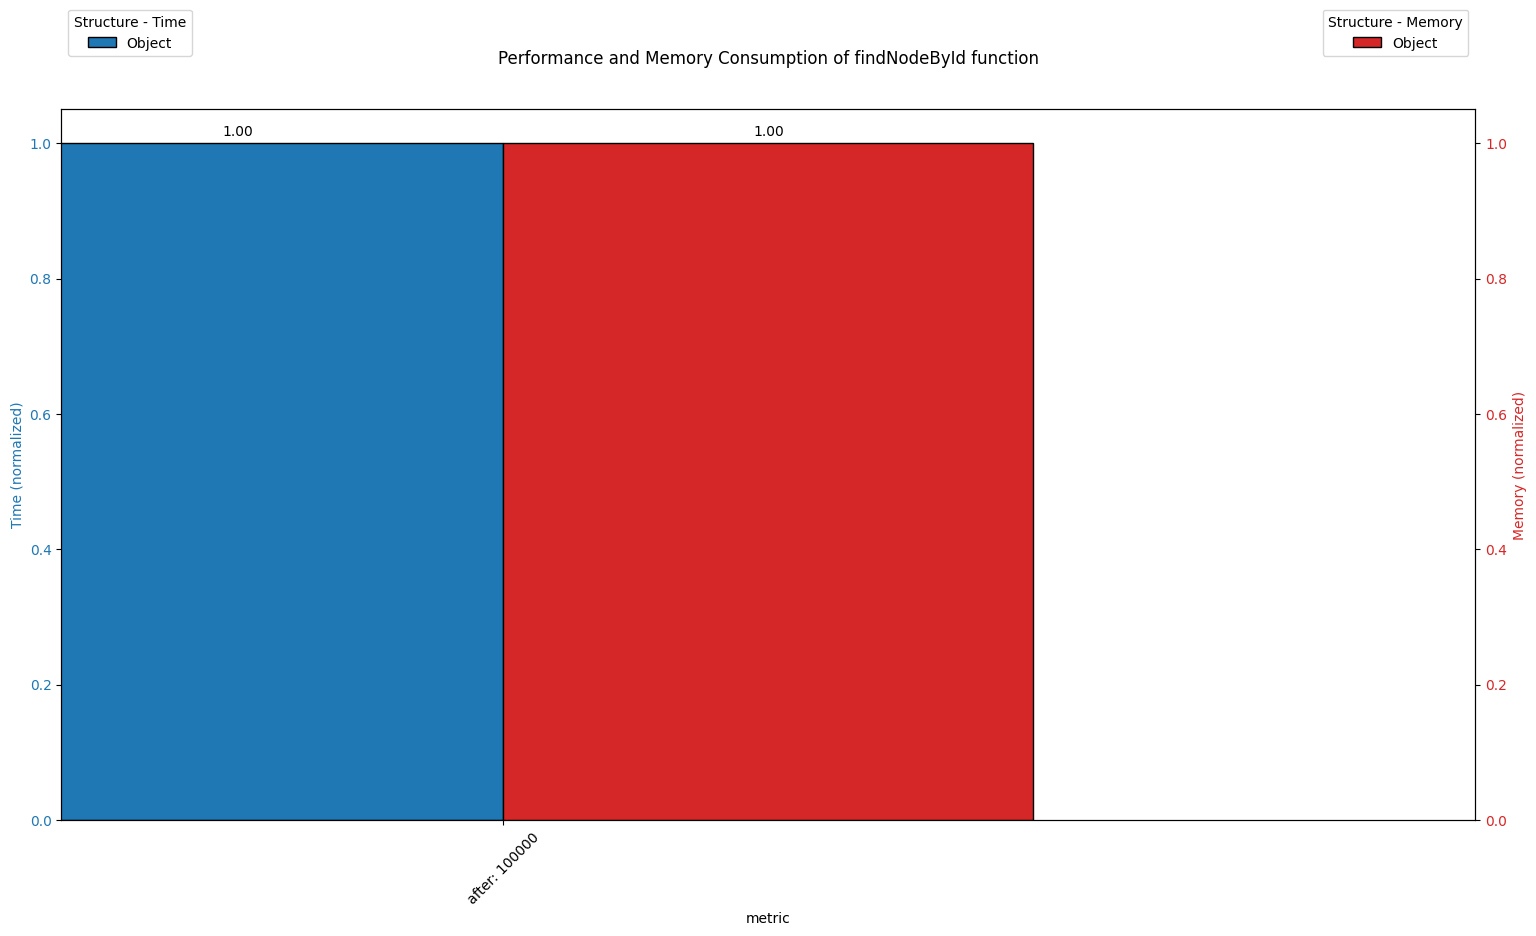

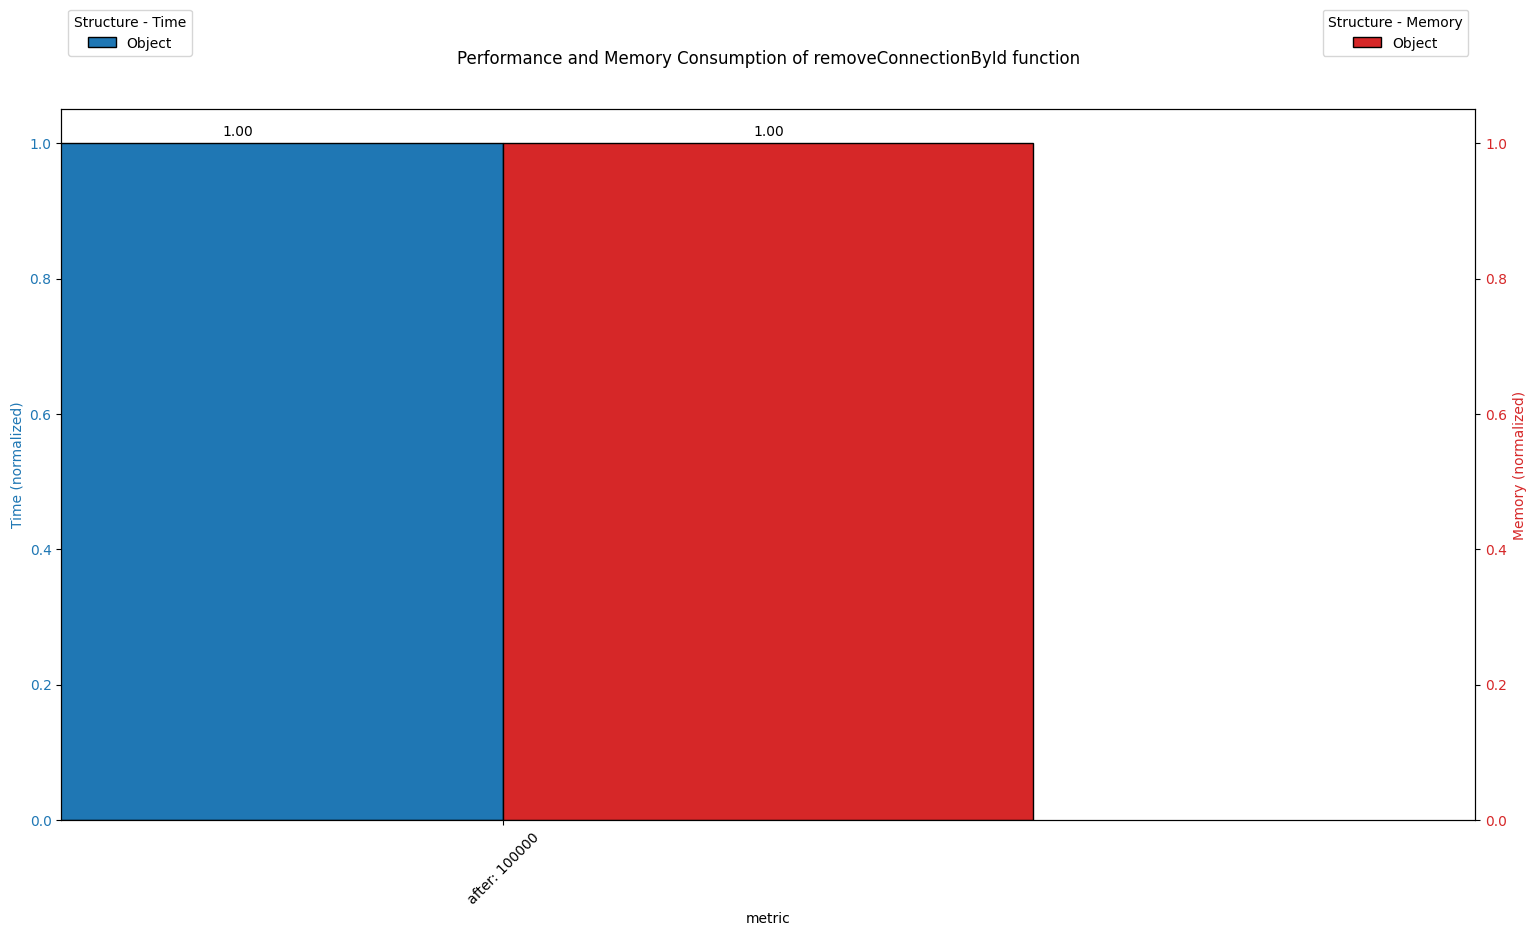

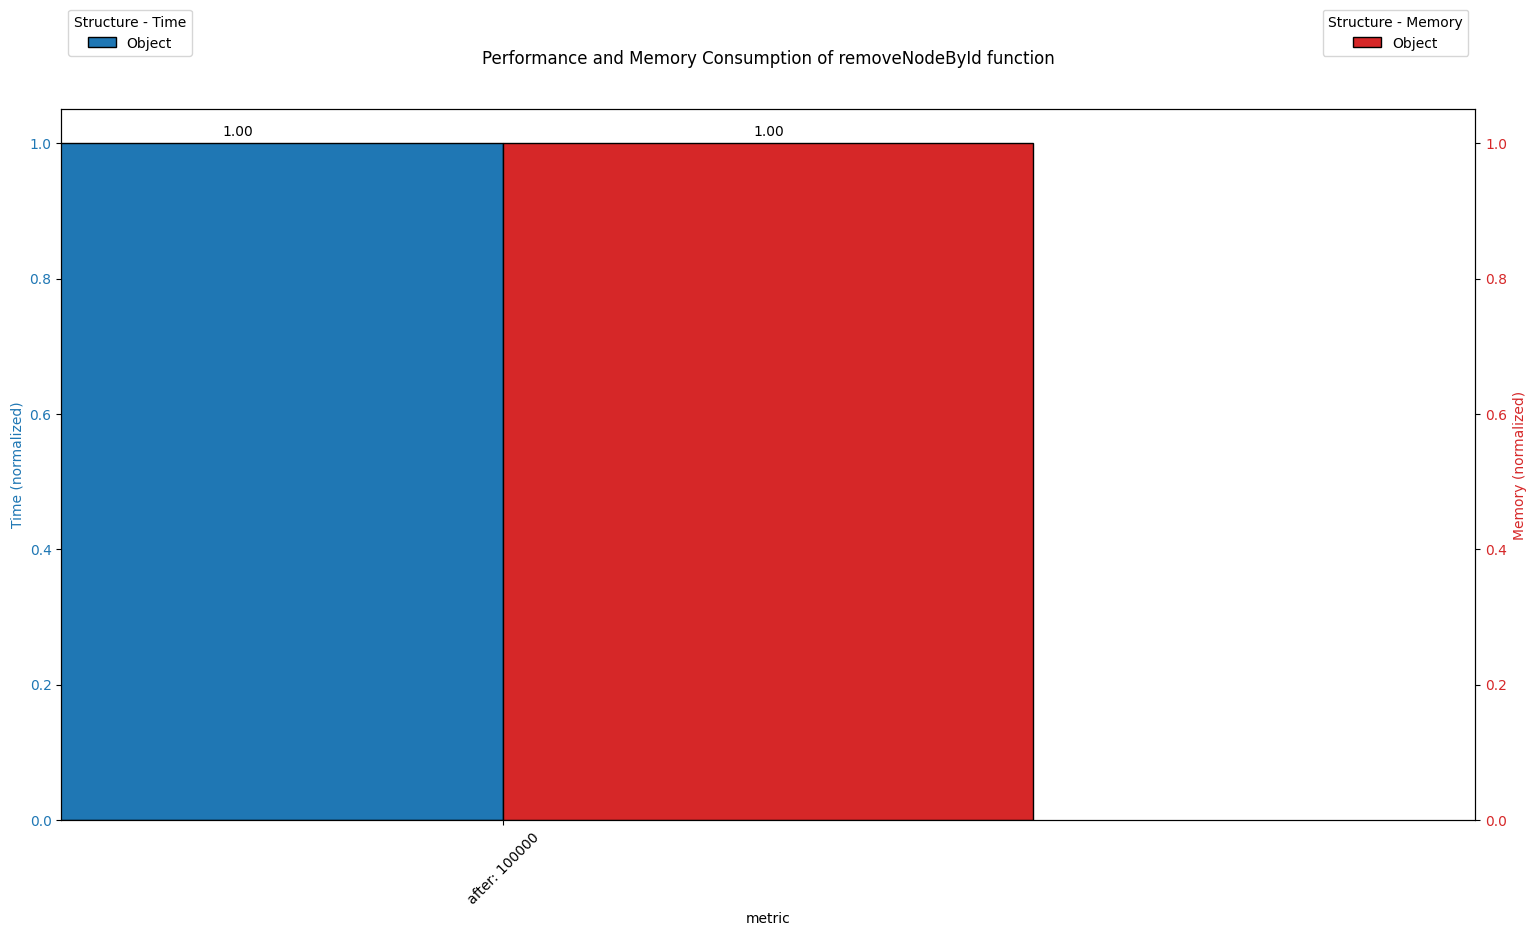

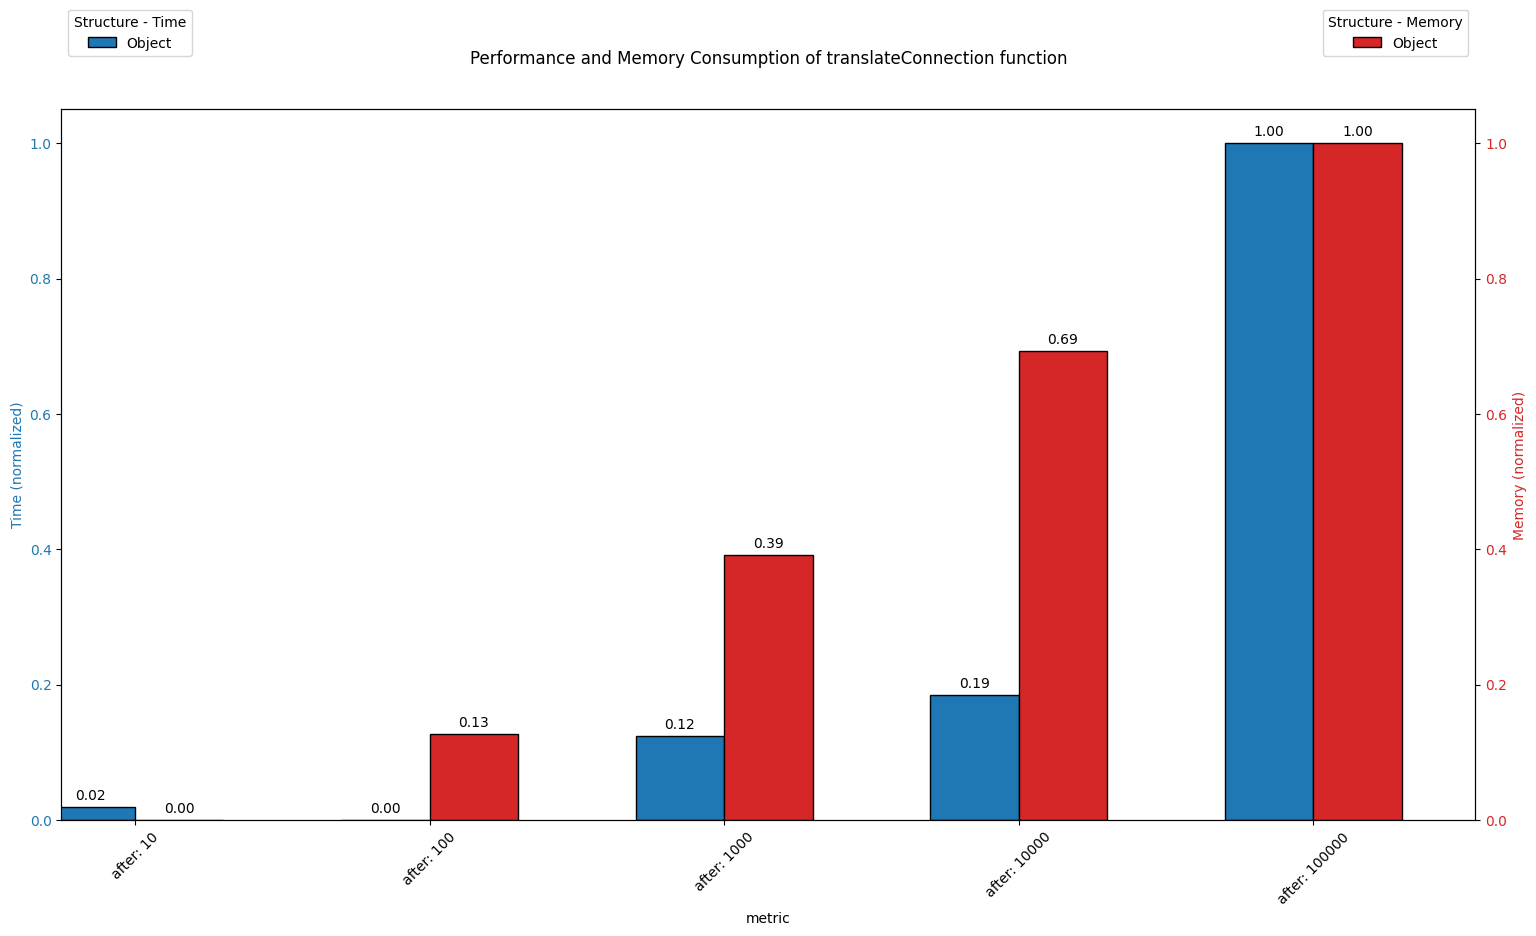

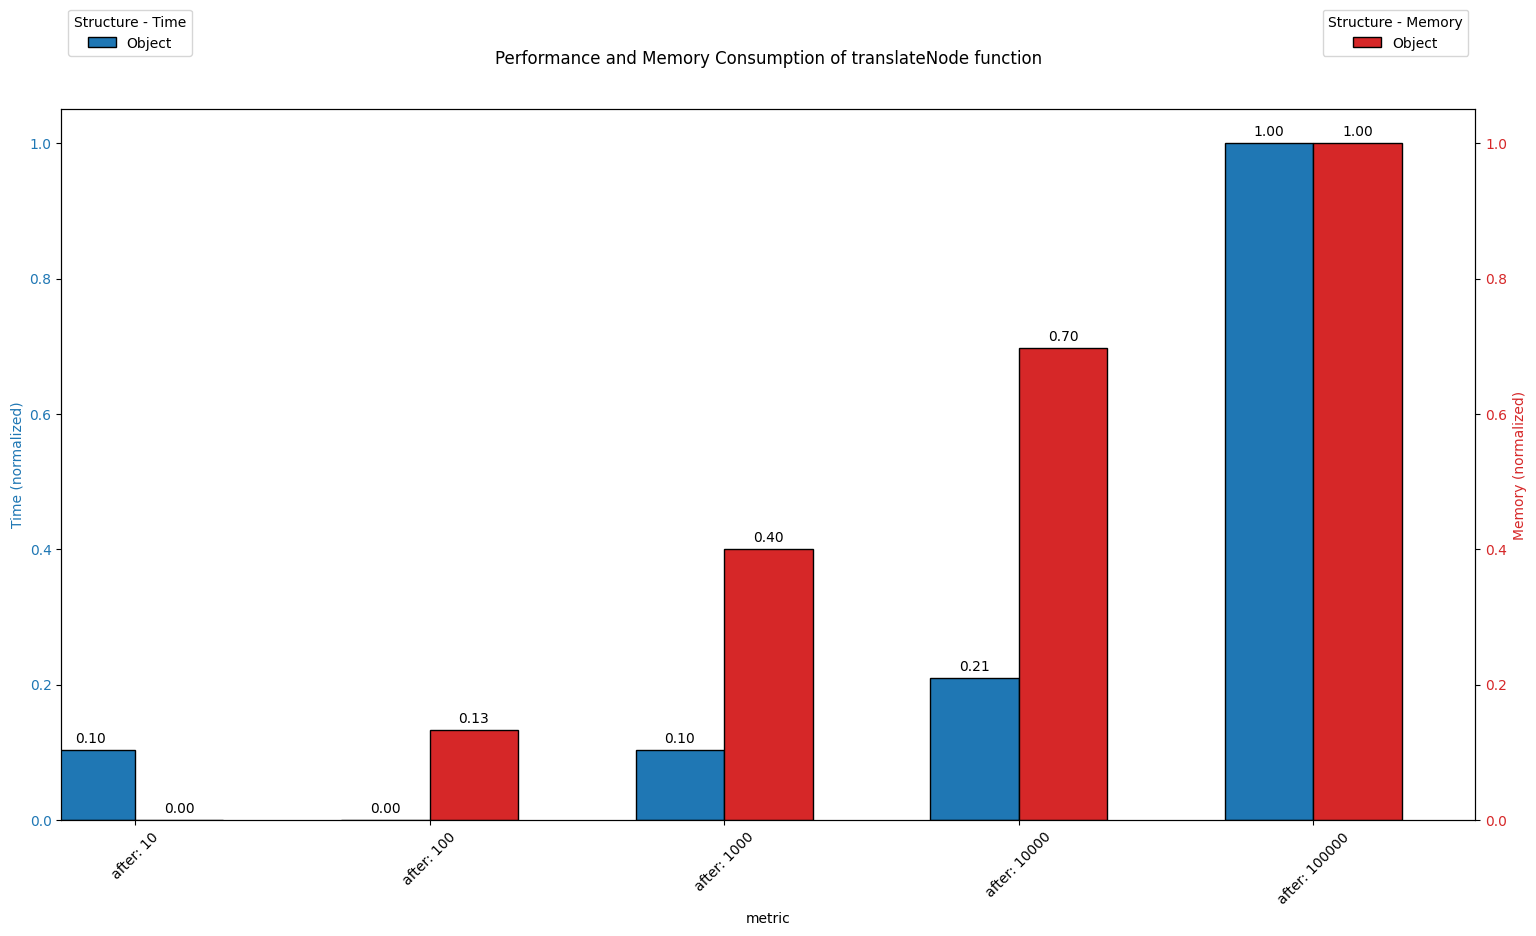

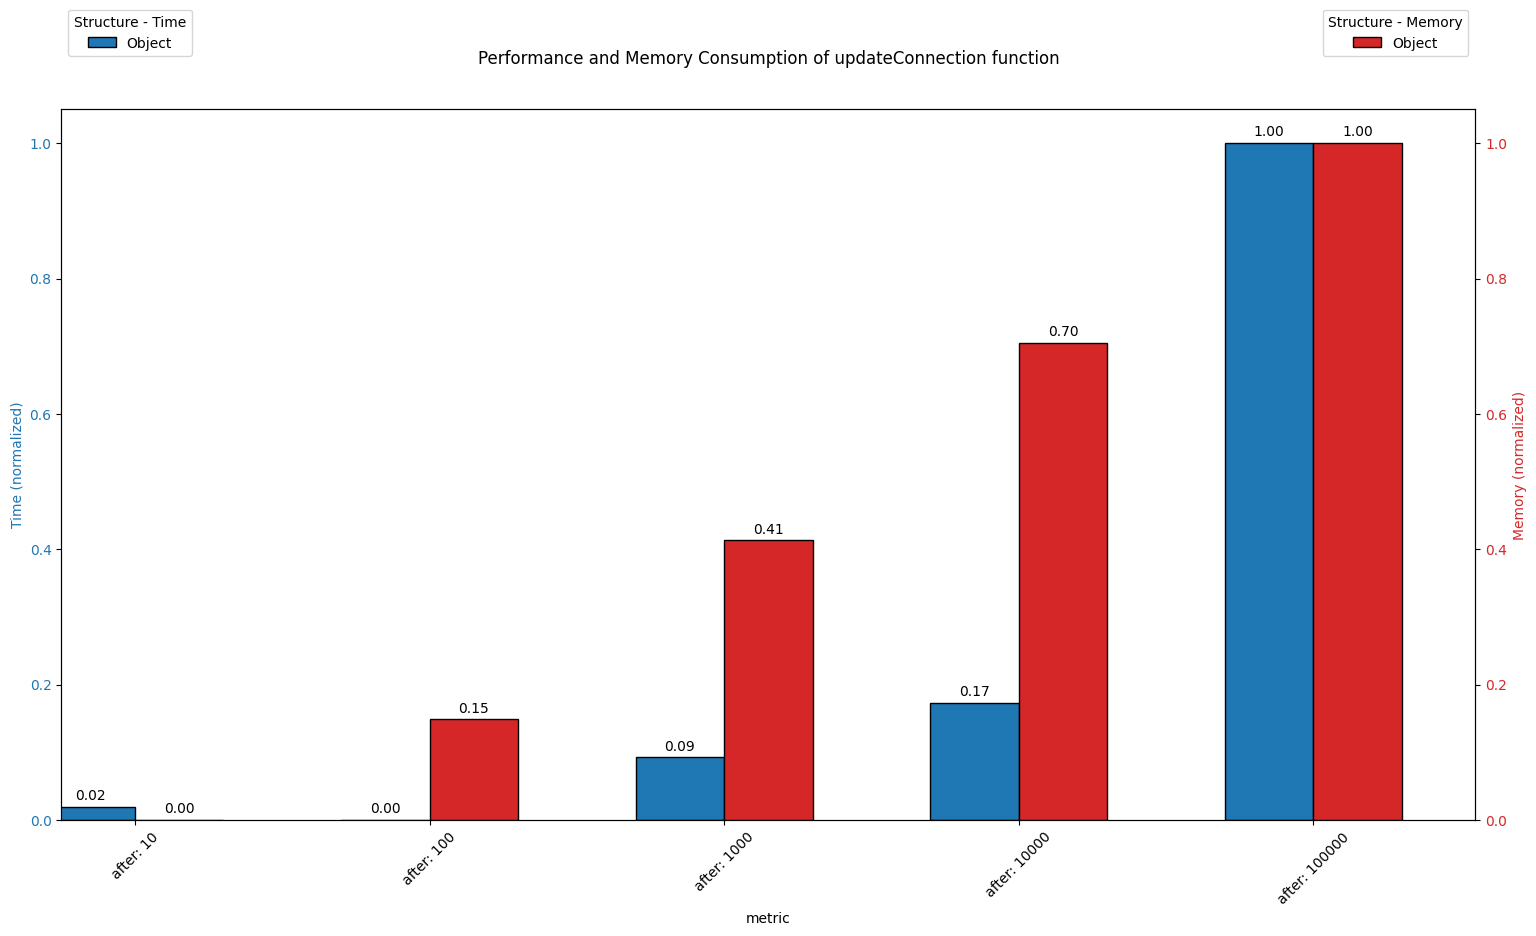

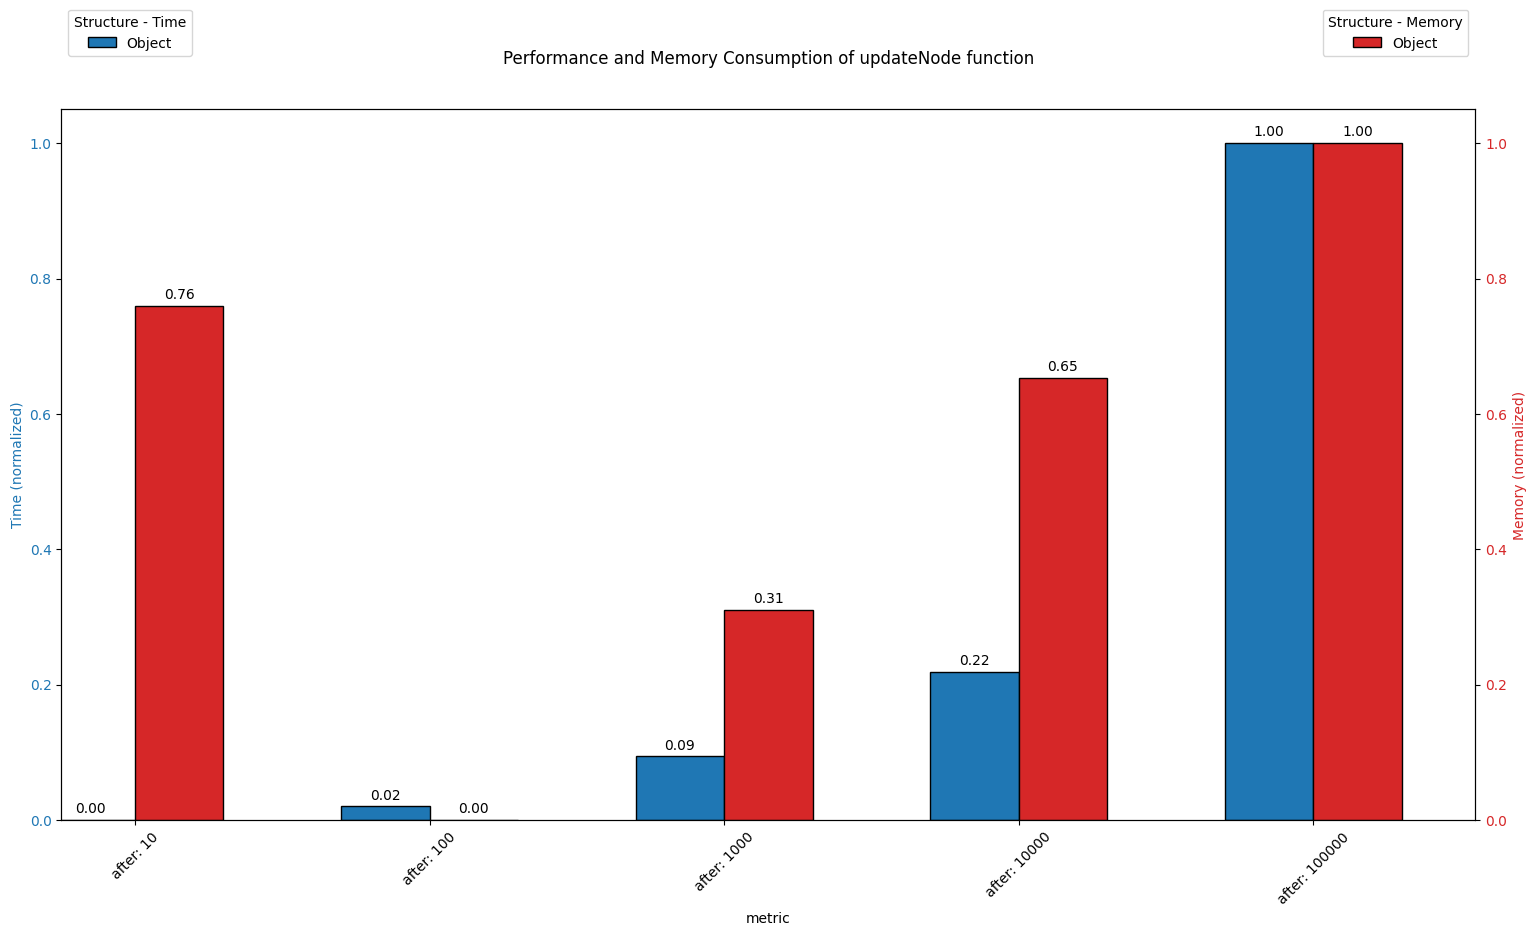

In [74]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to process each data file
def process_data(file_path):
    with open(file_path) as f:
        data = json.load(f)

    performance_rows = []
    memory_rows = []

    for entry in data:
        measurement = entry['measurement']
        
        if 'performance' in measurement:
            structure = measurement['performance']['structure']
            action = measurement['performance']['action']
            qty_or_after = measurement['performance'].get('qty', measurement['performance'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['performance'] else 'after'
            time = measurement['performance']['time']
            performance_rows.append([structure, action, metric_type, qty_or_after, time])
        
        if 'memory' in measurement:
            structure = measurement['memory']['structure']
            action = measurement['memory']['action']
            qty_or_after = measurement['memory'].get('qty', measurement['memory'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['memory'] else 'after'
            size = measurement['memory']['size']
            memory_rows.append([structure, action, metric_type, qty_or_after, size])

    performance_df = pd.DataFrame(performance_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'time'])
    memory_df = pd.DataFrame(memory_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'size'])
    
    return performance_df, memory_df

# Process all files
performance_dfs = []
memory_dfs = []

# Assuming there are multiple files benchmark.report.1.json, benchmark.report.2.json, benchmark.report.3.json
for i in range(1, 4):
    perf_df, mem_df = process_data(f"../output/specReports/benchmark.report.{i}.json")  # Update the path if needed
    performance_dfs.append(perf_df)
    memory_dfs.append(mem_df)

# Concatenate dataframes
all_performance_df = pd.concat(performance_dfs)
all_memory_df = pd.concat(memory_dfs)

# Group by necessary columns and calculate the mean
performance_df = all_performance_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()
memory_df = all_memory_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()

# Log1p Transformation with handling zero/negative values
excluded_actions = [
    'addNodeMetadata', 
    'findNodeById', 
    'findConnectionById',
    'removeNodeById',
    'removeConnectionById',
    'updateNodeMetadata',
]

def log1p_transform(df, value_column, excluded_actions):
    epsilon = 1e-10  # Small constant to avoid log(0)
    df[value_column] = df.apply(
        lambda row: np.log1p(row[value_column] + epsilon) if row['action'] not in excluded_actions and row[value_column] > 0 else row[value_column], 
        axis=1
    )
    return df

# Apply log1p transformation to time and size columns
performance_df = log1p_transform(performance_df, 'time', excluded_actions)
memory_df = log1p_transform(memory_df, 'size', excluded_actions)

# Normalize data within each action
def normalize(df, value_column):
    min_value = df[value_column].min()
    max_value = df[value_column].max()
    if min_value != max_value:  # Avoid division by zero and NaN values
        df[value_column] = (df[value_column] - min_value) / (max_value - min_value)
    else:
        df[value_column] = 1  # If all values are the same, set them to 1
    return df

# Normalize time and size columns
performance_df = performance_df.groupby(['action']).apply(normalize, 'time').reset_index(drop=True)
memory_df = memory_df.groupby(['action']).apply(normalize, 'size').reset_index(drop=True)

# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=['structure', 'action', 'metric_type', 'metric_value'], suffixes=('_time', '_memory'))

# Combine metric type and value for unique x-axis labels
merged_df['metric'] = merged_df['metric_type'] + ': ' + merged_df['metric_value'].astype(str)

# Plotting the combined graphs with log1p scale and annotations
def plot_combined_graph(df, action):
    subset = df[df['action'] == action]
    pivot_time_df = subset.pivot(index='metric', columns='structure', values='time')
    pivot_memory_df = subset.pivot(index='metric', columns='structure', values='size')

    fig, ax1 = plt.subplots(figsize=(16, 9))  # Increase figure size

    bar_width = 0.3  # Adjust the bar width
    rotation_angle = 45  # Adjust the rotation angle for x-tick labels

    # Plot time bars
    ax1.set_xlabel('Metric (qty/after)')
    ax1.set_ylabel('Time (normalized)', color='tab:blue')
    bars1 = pivot_time_df.plot(
        kind='bar', ax=ax1, position=1, width=bar_width, 
        color=['tab:blue', 'tab:cyan'], legend=False, edgecolor='black'
    )
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Plot memory bars
    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory (normalized)', color='tab:red')
    bars2 = pivot_memory_df.plot(
        kind='bar', ax=ax2, position=0, width=bar_width, 
        color=['tab:red', 'tab:pink'], legend=False, edgecolor='black'
    )
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.tick_params(axis='x', labelrotation=rotation_angle)  # Rotate x-tick labels for better readability

    # Annotate bars with their values
    def annotate_bars(ax, bars):
        for bar in bars.patches:
            height = bar.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height), 
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", 
                            ha='center', va='bottom', color='black'
                            )

    annotate_bars(ax1, bars1)
    annotate_bars(ax2, bars2)

    fig.tight_layout(pad=3)
    fig.suptitle(f'Performance and Memory Consumption of {action} function', y=1.02)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), title='Structure - Time')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), title='Structure - Memory')

    plt.show()

    # Save the plot as an image
    plot_dir = "../output/plots"
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    fig.savefig(f'{plot_dir}/{action}_combined.png', bbox_inches='tight')  # Change the path as per your file locations

keys = [
    "addConnection",
    "addConnections",
    "addNode",
    "addNodes",
    "addNodeMetadata",
    "updateNodeMetadata",
    "findConnectionById",
    "findNodeById",
    "removeConnectionById",
    "removeNodeById",
    "translateConnection",
    "translateNode",
    "updateConnection",
    "updateNode"
]

# Plot combined graphs for each action
for action in sorted(merged_df['action'].unique(), key=lambda x: keys.index(x)):
    plot_combined_graph(merged_df, action)
